# ACDC Unet LV binary segmentation

In [1]:
import cv2
import torch
from torch import nn
import os
from datetime import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch import nn
import albumentations as A
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import segmentation_models_pytorch as smp
import torch
from torch.utils import data
from torch import nn 
import torchvision.transforms.functional as TF
import glob
import torch.nn.functional as F

%matplotlib inline

## loss

In [20]:
def my_cross_entropy(x, y, ignore_classes = [1, 3]):
    
    for class_to_ignore in ignore_classes:
        x[:,class_to_ignore,:,:] = 0
    log_prob = -1.0 * F.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss


criterion = nn.CrossEntropyLoss()

batch_size = 2
nb_classes = 7
H = W = 224
x = torch.randn(batch_size, nb_classes, H, W, requires_grad=True)
y = torch.randint(0, nb_classes, (batch_size, H, W,))

print(x.size())
print(y.size())

loss_reference = criterion(x, y)
loss = my_cross_entropy(x, y, ignore_classes=[1,3])

print(loss_reference, loss)


torch.Size([2, 7, 224, 224])
torch.Size([2, 224, 224])
tensor(2.3511, grad_fn=<NllLoss2DBackward>) tensor(2.2466, grad_fn=<MeanBackward0>)


In [18]:
x[:,3,:,:].shape

torch.Size([2, 224, 224])

In [145]:
#m = nn.LogSoftmax(dim=1)
#loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
#input = torch.randn(3, 5, requires_grad=True)
#        >>> # each element in target has to have 0 <= value < C
#        >>> target = torch.tensor([1, 0, 4])
#        >>> output = loss(m(input), target)
 #       >>> output.backward()
 #       >>>
 #       >>>
# 2D loss example (used, for example, with image inputs)
N, C = 2, 4
loss = nn.NLLLoss()
# input is of size N x C x height x width
data = torch.randn(N, 4, 5, 5)
print('data ', data)
conv = nn.Conv2d(4, C, (3, 3))
m = nn.LogSoftmax(dim=1)
# each element in target has to have 0 <= value < C
target = torch.empty(N, 3, 3, dtype=torch.long).random_(0, C)
print('target', target)
output = loss(m(conv(data)), target)
print('output ', output)
output.backward()
print('output ', output)

data  tensor([[[[ 1.8024,  0.2170, -1.0110, -0.2885,  0.5040],
          [-0.3321, -0.5446,  0.4711,  0.9342, -0.7548],
          [-0.4023,  0.4696, -0.0506,  0.3547, -0.0896],
          [-0.4452, -0.7943,  1.0527, -0.9382,  2.7625],
          [ 0.8164, -0.3829, -2.3803, -1.7658, -0.0858]],

         [[ 0.9021,  0.8658, -1.7804, -1.4865,  0.5524],
          [ 1.1675,  0.4523, -0.5718, -1.2060, -0.6081],
          [-1.3152,  0.7345,  0.4417, -0.3739,  0.0180],
          [-0.8019, -1.0485, -1.4722, -0.7708,  0.0575],
          [ 1.9275,  1.3463, -0.1384, -0.9875, -0.5424]],

         [[ 0.9843, -1.1042, -0.0420, -1.1438,  1.4974],
          [-0.1491,  0.5231, -1.0844, -1.5069, -0.3912],
          [-0.7154, -1.3653, -2.0340, -1.3757, -0.6807],
          [-1.3310,  0.6489, -0.5011,  0.2436, -0.5862],
          [ 0.5937, -1.1158,  0.4776,  0.9535,  0.4408]],

         [[-0.7610,  0.4592,  1.3537, -0.2722, -0.9178],
          [-0.2481,  0.5552, -0.2803, -0.9803,  1.1295],
          [-1.1061,

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
path = '/home/euloo/Documents/datasets/acdc/'

In [5]:
!ls -lah /home/euloo/Documents/datasets/acdc/patient002/

total 18M
drwxr-xr-x   2 euloo euloo 4.0K Jun 12  2017 .
drwx------ 104 euloo euloo 4.0K Jul 11 08:57 ..
-rw-r--r--   1 euloo euloo   63 Mar 21  2017 Info.cfg
-rwxrwx---   1 euloo euloo  17M Mar 21  2017 patient002_4d.nii.gz
-rw-r--r--   1 euloo euloo 7.1K Jun  8  2017 patient002_frame01_gt.nii.gz
-rw-r--r--   1 euloo euloo 599K Mar 21  2017 patient002_frame01.nii.gz
-rw-r--r--   1 euloo euloo 6.4K Jun  8  2017 patient002_frame12_gt.nii.gz
-rw-r--r--   1 euloo euloo 600K Mar 21  2017 patient002_frame12.nii.gz


In [6]:
img = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame01.nii.gz')
msk = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame01_gt.nii.gz')
img12 = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame13.nii.gz')
msk12 = nib.load('/home/euloo/Documents/datasets/acdc/patient008/patient008_frame13_gt.nii.gz')

In [7]:
img.shape, msk.shape

((200, 256, 10), (200, 256, 10))

In [8]:
img = img.get_fdata()
msk = msk.get_fdata()
img12 = img12.get_fdata()
msk12 = msk12.get_fdata()

In [9]:
img.shape

(200, 256, 10)

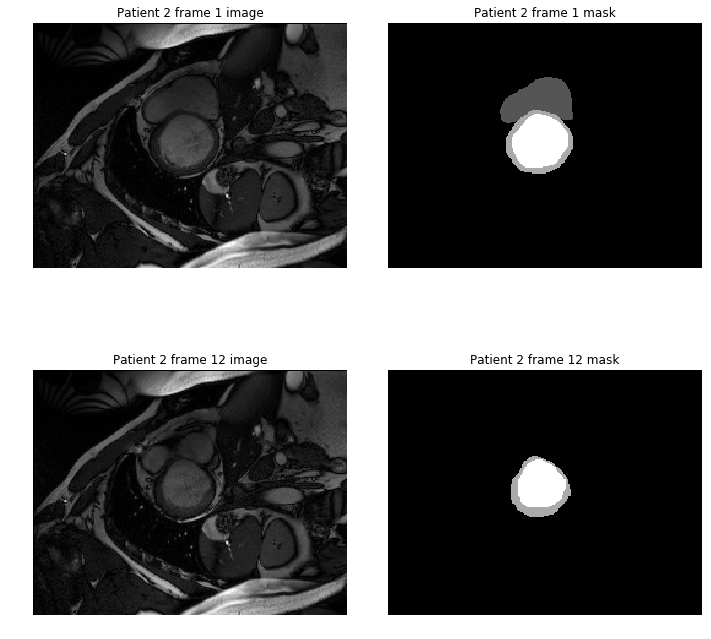

In [10]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.title('Patient 2 frame 1 image')
plt.imshow(img[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(222)
plt.title('Patient 2 frame 1 mask')
plt.imshow(msk[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(223)
plt.title('Patient 2 frame 12 image')
plt.imshow(img12[:,:,0], cmap = 'gray')
plt.axis('off')
plt.subplot(224)
plt.title('Patient 2 frame 12 mask')
plt.imshow(msk12[:,:,0], cmap = 'gray')
plt.axis('off')
plt.tight_layout()

In [11]:
!ls /home/euloo/Documents/datasets/acdc/

images		     patient016  patient034  patient052  patient070  patient088
masks		     patient017  patient035  patient053  patient071  patient089
patient001	     patient018  patient036  patient054  patient072  patient090
patient001.Info.cfg  patient019  patient037  patient055  patient073  patient091
patient002	     patient020  patient038  patient056  patient074  patient092
patient003	     patient021  patient039  patient057  patient075  patient093
patient004	     patient022  patient040  patient058  patient076  patient094
patient005	     patient023  patient041  patient059  patient077  patient095
patient006	     patient024  patient042  patient060  patient078  patient096
patient007	     patient025  patient043  patient061  patient079  patient097
patient008	     patient026  patient044  patient062  patient080  patient098
patient009	     patient027  patient045  patient063  patient081  patient099
patient010	     patient028  patient046  patient064  patient082  patient100
patient011	     patient029 

In [12]:
bashCommand = "ls -R | grep -v 'gt.nii.gz$'"
import subprocess
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [13]:
ls -R /home/euloo/Documents/datasets/acdc/patient043 | grep -v 'gt.nii.gz$'

/home/euloo/Documents/datasets/acdc/patient043:
Info.cfg
patient043_4d.nii.gz
patient043_frame01_gt.nii.gz
patient043_frame01.nii.gz
patient043_frame07_gt.nii.gz
patient043_frame07.nii.gz


# 3 classes 

%%time

for root, subdirs, files in os.walk(path):
    #list_file_path = os.path.join(root, 'my-directory-list.txt')
    for file in glob.glob(root + '/*.nii.gz'):
        if 'gt' in file:
            
            #print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'masks', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                #print(saving_path)
            
                plt.imsave(saving_path, slice_i, format='png', cmap='gray')
        elif '4d' not in file:
            #print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'images', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                #print(saving_path)
            
                #plt.imsave(saving_path, slice_i, format='png', cmap='gray')
                #img = Image.fromarray(slice_i)
                #img.save(saving_path)
                cv2.imwrite(saving_path, slice_i)


# 1 class LV


%%time

for root, subdirs, files in os.walk(path):
    #list_file_path = os.path.join(root, 'my-directory-list.txt')
    for file in glob.glob(root + '/*.nii.gz'):
        if 'gt' in file:
            
            #print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'masks', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                #print(saving_path)
            
                plt.imsave(saving_path, slice_i == 3, format='png', cmap='gray')
        elif '4d' not in file:
            #print(file)
            epi_img_data = nib.load(file).get_fdata()
            for i in range(epi_img_data.shape[-1]):

                slice_i = epi_img_data[:,:, i]
                saving_path = os.path.join(path, 'images', file[file.rfind('/') + 1: file.find('.')] + f'{i}.png')
                #print(saving_path)
            
                #plt.imsave(saving_path, slice_i, format='png', cmap='gray')
                #img = Image.fromarray(slice_i)
                #img.save(saving_path)
                cv2.imwrite(saving_path, slice_i)


In [176]:
f = [1, 2, 3]
random.shuffle(f)
print(f)

[3, 2, 1]


In [3]:
T = transforms.Compose([
    #transforms.Resize([224,224]),

    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
M = transforms.Compose([
    #transforms.CenterCrop(224),
    #A.CenterCrop(224, 224),
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    #transforms.ToTensor(),
    #transforms.Resize([224,224]),
    #transforms.ToTensor(),
])
def get_train_transforms():
    return A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.RandomRotate90(p=0.5),
        #A.Resize(height=512, width=512, p=1.0),
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225],),]
        A.CenterCrop(224, 224),
        #ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=512, width=512, p=1.0),
        #A.Normalize(mean=[0.485, 0.456, 0.406],
        #            std=[0.229, 0.224, 0.225],),
        ToTensorV2(p=1.0),
        ], p=1.0)

class Dataset(data.Dataset):
    def __init__(self, paths, subset = 'train', transform = None):
        img_pathes = []
        msk_pathes = []
        dataset_index = []
        for i in range(len(paths)): # acdc or emidec
            for folder in os.listdir(paths[i]): # images or masks
                pathes = []
                for pth, dirs, files in os.walk(os.path.join(paths[i], folder)):
                    for file in files:
                        pathes.append(os.path.join(pth, file))
                    dataset_index.extend([i] * (len(files) // 2)) # awful
                if folder == 'images':
                    img_pathes.extend(pathes)
                elif folder == 'masks':
                    msk_pathes.extend(pathes)
                



            items = list(zip(img_pathes, msk_pathes, dataset_index))
            random.shuffle(items)
        
        if subset == 'train':
            self.items = items[: int(.7 * len(items))]
        elif subset == 'valid':
            self.items = items[int(.7 * len(items)): int(.9 * len(items))]
        elif subset == 'test':
            self.items = items[int(.9 * len(items)):]
        
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name, dataset_num = self.items[index]

        #image = Image.open(img_name).convert('L')
        #mask = Image.open(msk_name).convert('L')
        image = cv2.imread(img_name, 0)#.astype(np.float32)
        mask = cv2.imread(msk_name, 0)


        

        #mask = torch.tensor(np.asarray(mask)).long()
        #image = transforms.ToTensor()(image)
        
        #image = A.CenterCrop(224, 224)(image)
        #mask = A.CenterCrop(224, 224)(mask)
        #image = transforms.CenterCrop((224, 224))(image)
        #albumentations.augmentations.transforms.CenterCrop(image)
        
        #print('image', image, image.max())
        #print('mask', mask, mask.max()) # wtf 10 17
        #mask = torch.tensor(np.asarray(mask))
        #mask = mask.unsqueeze(0)
        if self.transform:

            #image = self.transform(image) # resize + to tensor
            #mask = self.transform(mask)
            mask = M(mask) # resize
            image = M(image)
            #print('image', image, image.getextrema())
            #print('mask', mask, mask.getextrema()) # wtf 10 17
            mask = torch.tensor(np.asarray(mask)).long()
            image = transforms.ToTensor()(image)
            #mask = torch.tensor(mask).long()
            #mask[mask == 4] = 0
        
        return image, mask, dataset_num

In [4]:
#path = '/home/euloo/Documents/datasets/heart_segmentation/acdc/'
paths = ['/home/euloo/Documents/datasets/heart_segmentation/acdc/',
        '/home/euloo/Documents/datasets/heart_segmentation/emidec/']

In [5]:
train_data = Dataset(paths, subset='train', transform=get_train_transforms())
valid_data = Dataset(paths, subset='valid', transform=get_train_transforms())
test_data = Dataset(paths, subset='test', transform=get_train_transforms())

In [6]:
train_data.__len__(), valid_data.__len__(), test_data.__len__()

(1826, 523, 261)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=32, 
                                           shuffle=True,
                                            num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=32, 
                                           shuffle=False,
                                          num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False,
                                         num_workers=4)

In [7]:
len(train_loader), len(valid_loader), len(test_loader)

(58, 17, 261)

In [9]:
train_data[5]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5255, 0.4941, 0.4980,  ..., 0.3922, 0.3725, 0.3843],
          [0.5294, 0.5020, 0.5098,  ..., 0.3961, 0.3765, 0.3882],
          [0.4863, 0.5059, 0.4980,  ..., 0.3882, 0.3647, 0.3686]]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 1)

In [10]:
i, m, j = train_data[10]
print(i.size(),i.min(), i.max(), j)
print(m.size(), m.min(), m.max())

torch.Size([1, 224, 224]) tensor(0.) tensor(0.9373) 1
torch.Size([224, 224]) tensor(0) tensor(2)


In [11]:
fuck = []
on = 0
ze = 0
for i in range(len(train_data)):
    _, __, j = train_data[i]
    if j == 0:
        ze += 1
    elif j == 1:
        on += 1
    else:
        print('wtf')
ze, on

(1318, 508)

In [12]:
min(fuck), max(fuck)

ValueError: min() arg is an empty sequence

In [9]:
images = next(iter(train_loader))

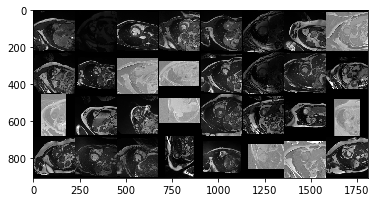

In [10]:
images, masks, dataset_nums = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

In [12]:
dataset_nums

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0])

In [191]:
#model = smp.Unet(in_channels=1, classes=5).to(device) # , activation='softmax'

In [320]:
model.decoder.blocks[-1].attention2

Attention(
  (attention): Identity()
)

In [317]:
model.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [8]:
class Model(nn.Module): 
    def __init__(self, net='unet', in_channels = 1, classes = 7):
        super(Model, self).__init__()
        self.net = net
        if self.net == 'unet':
            self.model = smp.Unet(in_channels = in_channels, classes = classes)
            self.model.segmentation_head2 = nn.Conv2d(in_channels = 16, 
                                                     out_channels = classes, 
                                                     kernel_size = (3, 3),
                                                     stride = (1, 1),
                                                     padding = (1, 1))

            
            
        elif self.net == 'fpn':
            pass
        elif self.net == 'fcn':
            pass

    def forward(self, x):
        if (self.net == 'unet'):
            features = self.model.encoder(x)
            #x = self.model.decoder.blocks[-1].attention2(x)
            decoder_output = self.model.decoder(*features)
            masks_acdc = self.model.segmentation_head(decoder_output)
            masks_emidec = self.model.segmentation_head2(decoder_output)
        

        
        return (masks_acdc, masks_emidec)


In [9]:
model = Model(net='unet', in_channels=1, classes=7).to(device)

In [14]:
#model = smp.Unet(in_channels=3, classes=7).to(device) # , activation='softmax'

In [12]:
model.model.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [13]:
model.model.segmentation_head2

Conv2d(16, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [10]:
optimizer = torch.optim.Adam([
    {'params': model.model.decoder.parameters(), 'lr': 1e-3},     

    {'params': model.model.encoder.parameters(), 'lr': 1e-5},  
])

In [16]:
# ignore classes, not full samples
def cross_entropy_ignore_classes(x, y, ignore_classes = [1, 3]): 
    for class_to_ignore in ignore_classes:
        x[:,class_to_ignore,:,:] = 0
    log_prob = -1.0 * F.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss
# ignore datasets inside batch
def cross_entropy_ignore_dataset(x, y, ignore_dataset = 0, datasets_indexes = [0,1]):
    batch_size = datasets_indexes.size()[0]
    for i in range(batch_size):
        if datasets_indexes[i] == ignore_dataset:
            tmp = x.clone() # no inplace
            tmp[i,:,:,:] = 0
            x = tmp
            tmp = y.clone()
            tmp[i] = 0
            y = tmp
    log_prob = -1.0 * F.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss

- use nn.CrossEntropyLoss as your criterion
- your model should output a tensor with the shape [batch_size, nb_classes, height ,width]
- the target should be a LongTensor with the shape [batch_size, height, width] and contain the class indices for each pixel location in the range [0, nb_classes-1]


If you are using nn.BCELoss, the output should use torch.sigmoid as the activation function. Alternatively, you won’t use any activation function and pass raw logits to nn.BCEWithLogitsLoss. If you use nn.CrossEntropyLoss for the multi-class segmentation, you should also pass the raw logits without using any activation function.

In [11]:
train_loss = []
val_loss = []

train_loss1 = []
train_loss2 = []

val_loss1 = []
val_loss2 = []

In [43]:
dataset_idx.size()[0]

32

In [12]:
criterion1 = nn.CrossEntropyLoss(weight = torch.tensor([1, 1, 1, 1, 0, 0, 0], dtype=torch.float32, device=device))
criterion2 = nn.CrossEntropyLoss(weight = torch.tensor([1, 0, 1, 0, 1, 1, 1], dtype=torch.float32, device=device))

In [13]:
%%time
for epoch in range(100):
    
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)
            epoch_loss = 0.
            epoch_loss1 = 0.
            epoch_loss2 = 0
            
            for i, data in enumerate(train_loader):
                inputs, masks, dataset_idx = data

                inputs = inputs.to(device)
                masks = masks.to(device)
                dataset_idx = dataset_idx.to(device)
                #print("inputs           ", inputs.size())
                #print("masks           ", inputs.size())
                #print('datas', dataset_idx.size())


                optimizer.zero_grad()
                outputs1, outputs2 = model(inputs)
                loss1 = criterion1(outputs1, masks.long())
                loss2 = criterion2(outputs2, masks.long())
                # acdc: ignore emidec classes 4(2) cavity, 5(3) myocardial infraction, 6(4) no reflow
                #acdc_cnt = (dataset_idx == 0).sum(dim=0)
                #emidec_cnt = dataset_idx.size()[0] - acdc_cnt
                #loss1 = cross_entropy_ignore_dataset(outputs1, masks.long(), ignore_dataset = 1, datasets_indexes = dataset_idx) 
                
                # emidec: ignore acdc classes 1 RV cavity, 3 LV cavity
                #loss2 = cross_entropy_ignore_dataset(outputs1, masks.long(), ignore_dataset = 0, datasets_indexes = dataset_idx) 
                loss =  loss1 + loss2
                loss.backward()

                optimizer.step()
                epoch_loss += loss.item()# / dataset_idx.size()[0]
                epoch_loss1 += loss1.item()# / acdc_cnt
                epoch_loss2 += loss2.item()# / emidec_cnt
                #print('epoch loss ', epoch_loss, '\r')
            
        elif phase == 'valid':
            model.train(False)
            validation_loss = 0.
            validation_loss1 = 0.
            validation_loss2 = 0.
            for i, data in enumerate(valid_loader):
                inputs, masks, dataset_idx = data

                inputs = inputs.to(device)
                masks = masks.to(device)
                dataset_idx = dataset_idx.to(device)
                
                outputs1, outputs2 = model(inputs)
                loss1 = criterion1(outputs1, masks.long())
                loss2 = criterion2(outputs2, masks.long())
                #acdc_cnt = (dataset_idx == 0).sum(dim=0)
                #emidec_cnt = dataset_idx.size()[0] - acdc_cnt
                #loss1 = nn.CrossEntropyLoss()(outputs1, masks.long())
                #loss2 = nn.CrossEntropyLoss()(outputs2, masks.long())
                #loss1 = cross_entropy_ignore_dataset(outputs1, masks.long(), ignore_dataset = 1, datasets_indexes = dataset_idx) 
                # emidec: ignore acdc classes 1 RV cavity, 3 LV cavity
                #loss2 = cross_entropy_ignore_dataset(outputs1, masks.long(), ignore_dataset = 0, datasets_indexes = dataset_idx) 
                loss =  loss1 + loss2
                
                #loss = nn.CrossEntropyLoss()(outputs, masks.long())
                validation_loss += loss.item() #/ dataset_idx.size()[0]# add scale loss by amount of images in batch
                validation_loss1 += loss1.item() #/ acdc_cnt
                validation_loss2 += loss2.item() #/ emidec_cnt
            #print('epoch ', epoch, ' train loss ', epoch_loss, ' val loss ', validation_loss)
            print('epoch {:3d}| TRAIN full loss {:6.2f} loss1 {:6.2f} loss2 {:6.2f}| VAL full loss {:6.2f} loss1 {:6.2f} loss2 {:6.2f}'.format(epoch, 
                                                                                                              epoch_loss, epoch_loss1, epoch_loss2, 
                                                                                                              validation_loss, validation_loss1, validation_loss2))
            train_loss.append(epoch_loss)
            train_loss1.append(epoch_loss1)
            train_loss2.append(epoch_loss2)
            val_loss.append(validation_loss)
            val_loss1.append(validation_loss1)
            val_loss2.append(validation_loss2)

epoch   0| TRAIN full loss 221.88 loss1 112.21 loss2 109.67| VAL full loss 64.54 loss1 33.16 loss2 31.38
epoch   1| TRAIN full loss 208.85 loss1 105.74 loss2 103.11| VAL full loss 60.85 loss1 30.89 loss2 29.96
epoch   2| TRAIN full loss 205.83 loss1 104.29 loss2 101.54| VAL full loss 62.44 loss1 32.44 loss2 30.00
epoch   3| TRAIN full loss 204.00 loss1 103.44 loss2 100.56| VAL full loss 59.68 loss1 30.13 loss2 29.54
epoch   4| TRAIN full loss 202.12 loss1 102.52 loss2 99.60| VAL full loss 59.31 loss1 30.09 loss2 29.22
epoch   5| TRAIN full loss 200.13 loss1 101.66 loss2 98.48| VAL full loss 58.63 loss1 29.76 loss2 28.87
epoch   6| TRAIN full loss 198.50 loss1 100.69 loss2 97.81| VAL full loss 57.75 loss1 29.23 loss2 28.52
epoch   7| TRAIN full loss 196.46 loss1 99.50 loss2 96.95| VAL full loss 57.48 loss1 29.15 loss2 28.32
epoch   8| TRAIN full loss 195.27 loss1 98.96 loss2 96.31| VAL full loss 56.86 loss1 28.82 loss2 28.03
epoch   9| TRAIN full loss 193.20 loss1 97.98 loss2 95.22| VAL

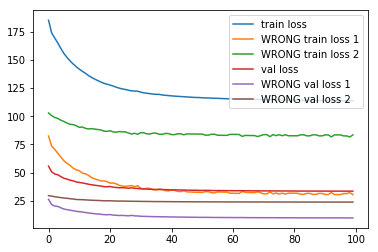

In [19]:
plt.plot(train_loss, label= 'train loss')
plt.plot(train_loss1, label= 'WRONG train loss 1')
plt.plot(train_loss2, label= 'WRONG train loss 2')
plt.plot(val_loss, label = 'val loss')
plt.plot(val_loss1, label = 'WRONG val loss 1')
plt.plot(val_loss2, label = 'WRONG val loss 2')
plt.legend();

In [52]:
img1, mask1, ind = test_data[12] # 8 - acdc 12 emidec

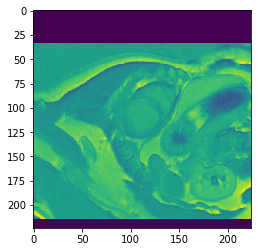

In [53]:
plt.imshow(img1[0,:,:])

In [54]:
mask_pred1, mask_pred2 = model(img1.unsqueeze(0).to(device))

In [55]:
mask_pred1.size()

torch.Size([1, 7, 224, 224])

In [56]:
mask_pred1[0,0,:,:].size()

torch.Size([224, 224])

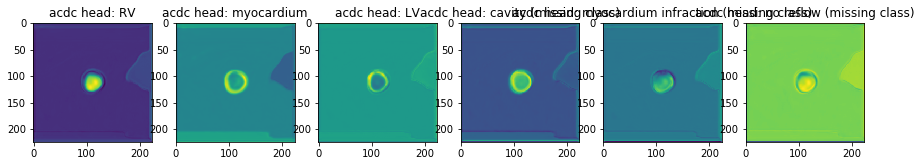

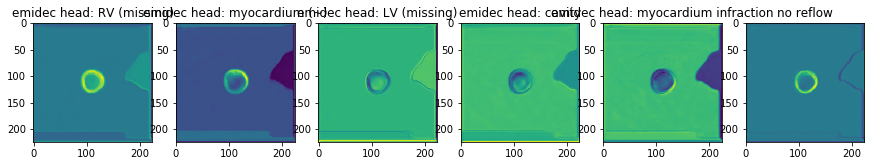

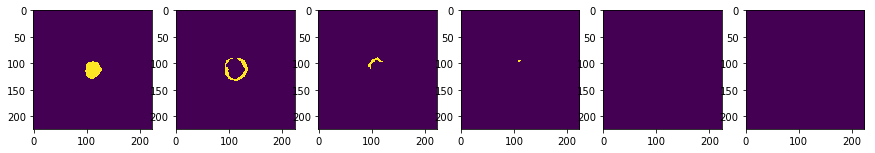

In [57]:
plt.figure(figsize=(20,8))
#plt.subplot(141)
#plt.title('background')
#plt.imshow(mask_pred1[0,0,:,:].cpu().detach().numpy())

plt.subplot(182)
plt.title('acdc head: RV')
plt.imshow(mask_pred1[0,1,:,:].cpu().detach().numpy())

plt.subplot(183)
plt.title('acdc head: myocardium')
plt.imshow(mask_pred1[0,2,:,:].cpu().detach().numpy())

plt.subplot(184)
plt.title('acdc head: LV')
plt.imshow(mask_pred1[0,3,:,:].cpu().detach().numpy());

plt.subplot(185)
plt.title('acdc head: cavity (missing class)')
plt.imshow(mask_pred1[0,4,:,:].cpu().detach().numpy())

plt.subplot(186)
plt.title('acdc head: myocardium infraction (missing class)')
plt.imshow(mask_pred1[0,5,:,:].cpu().detach().numpy())

plt.subplot(187)
plt.title('acdc head: no reflow (missing class)')
plt.imshow(mask_pred1[0,6,:,:].cpu().detach().numpy());

plt.figure(figsize=(20,8))
#plt.subplot(141)
#plt.title('background')
#plt.imshow(mask_pred1[0,0,:,:].cpu().detach().numpy())

plt.subplot(182)
plt.title('emidec head: RV (missing)')
plt.imshow(mask_pred2[0,1,:,:].cpu().detach().numpy())

plt.subplot(183)
plt.title('emidec head: myocardium (~)')
plt.imshow(mask_pred2[0,2,:,:].cpu().detach().numpy())

plt.subplot(184)
plt.title('emidec head: LV (missing)')
plt.imshow(mask_pred2[0,3,:,:].cpu().detach().numpy());

plt.subplot(185)
plt.title('emidec head: cavity')
plt.imshow(mask_pred2[0,4,:,:].cpu().detach().numpy())

plt.subplot(186)
plt.title('emidec head: myocardium infraction')
plt.imshow(mask_pred2[0,5,:,:].cpu().detach().numpy())

plt.subplot(187)
plt.title('no reflow')
plt.imshow(mask_pred2[0,6,:,:].cpu().detach().numpy());

plt.figure(figsize=(20,8))
#plt.subplot(141)
#plt.imshow(mask1==0)
plt.subplot(182)
plt.imshow(mask1==1)
plt.subplot(183)
plt.imshow(mask1==2)
plt.subplot(184)
plt.imshow(mask1==3)
plt.subplot(185)
plt.imshow(mask1==4)
plt.subplot(186)
plt.imshow(mask1==5);
plt.subplot(187)
plt.imshow(mask1==6);

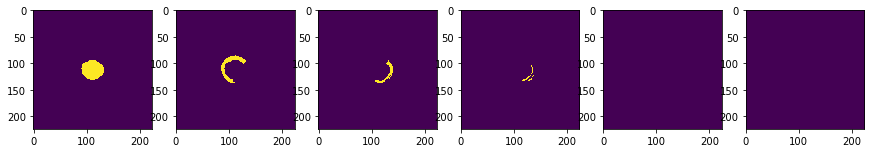

In [244]:
plt.figure(figsize=(20,8))
#plt.subplot(141)
#plt.imshow(mask1==0)
plt.subplot(182)
plt.imshow(mask1==1)
plt.subplot(183)
plt.imshow(mask1==2)
plt.subplot(184)
plt.imshow(mask1==3)
plt.subplot(185)
plt.imshow(mask1==4)
plt.subplot(186)
plt.imshow(mask1==5);
plt.subplot(187)
plt.imshow(mask1==6);

# test images

In [25]:
img1, mask1 = test_data[0]
img2, mask2 = test_data[1]
img3, mask3 = test_data[9]

In [27]:
#plt.imshow(img3.squeeze())

In [28]:
#plt.imshow(mask3.squeeze())

In [29]:
#mask_pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))

~~~
mask_pred1 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
mask_pred2 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
mask_pred3 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
fig_A = np.stack([
        img1.squeeze(),
        mask1.squeeze(),
        mask_pred1.squeeze().cpu().detach().numpy(),
    ], axis = 0)
fig_B = np.stack([
        img2.squeeze(),
        mask2.squeeze(),
        mask_pred2.squeeze().cpu().detach().numpy(),
    ], axis = 0)
fig_C = np.stack([
        img3.squeeze(),
        mask3.squeeze(),
        mask_pred3.squeeze().cpu().detach().numpy(),
    ], axis = 0)
figure = np.concatenate([fig_A, fig_B, fig_C], axis=1)

#figure = np.concatenate([it for it in figure],axis = 2)

figure = np.concatenate([it for it in figure],axis = 1)
plt.imsave('testtt'+ str(epoch) +'.png', figure)
~~~

In [37]:
%%time
max_score = 0

for epoch in range(0, 30):
    
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_loader)
    train_loss.append(train_logs['bce_loss'])
    train_iou.append(train_logs['iou_score'])
    train_fscore.append(train_logs['fscore'])
    
    valid_logs = valid_epoch.run(valid_loader)
    val_loss.append(valid_logs['bce_loss'])
    val_iou.append(valid_logs['iou_score'])
    val_fscore.append(valid_logs['fscore'])
    
    
    
    
    if epoch == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/42 [00:00<?, ?it/s]


/home/euloo/anaconda3/envs/py37/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss2d_forward

In [ ]:
# do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    mask_pred1 = torch.sigmoid(model(img1.unsqueeze(0).to(device)))
    mask_pred2 = torch.sigmoid(model(img2.unsqueeze(0).to(device)))
    mask_pred3 = torch.sigmoid(model(img3.unsqueeze(0).to(device)))
    fig_A = np.stack([
        img1.squeeze(),
        mask1.squeeze(),
        mask_pred1.squeeze().cpu().detach().numpy(),
        mask_pred1.squeeze().cpu().detach().numpy()> 0.5,
    ], axis = 0)
    fig_B = np.stack([
        img2.squeeze(),
        mask2.squeeze(),
        mask_pred2.squeeze().cpu().detach().numpy(),
        mask_pred2.squeeze().cpu().detach().numpy() > 0.5,
    ], axis = 0)
    fig_C = np.stack([
        img3.squeeze(),
        mask3.squeeze(),
        mask_pred3.squeeze().cpu().detach().numpy(),
        mask_pred3.squeeze().cpu().detach().numpy() > 0.5,
    ], axis = 0)
    figure = np.concatenate([fig_A, fig_B, fig_C], axis=1)

    #figure = np.concatenate([it for it in figure],axis = 2)

    figure = np.concatenate([it for it in figure],axis = 1)

    plt.imsave('test'+ str(epoch) +'.png', figure)
    

    

In [32]:
#train_logs

In [33]:
#test_logs = valid_epoch.run(test_loader)
#test_logs



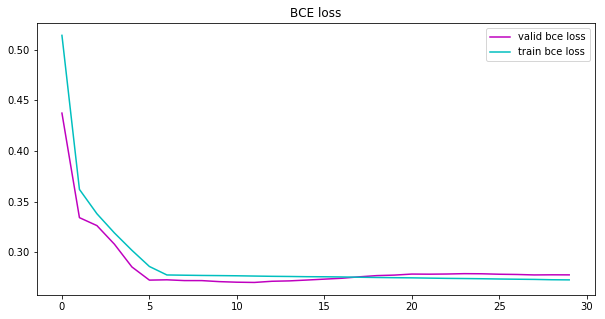

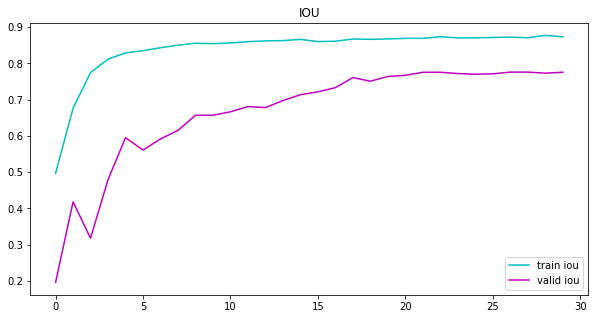

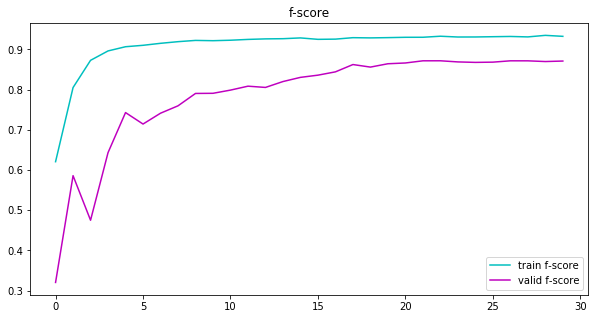

In [31]:


plt.figure(figsize=(10, 5))
plt.title("BCE loss")
plt.plot(val_loss, 'm', label='valid bce loss')
plt.plot(train_loss, 'c', label='train bce loss')
#plt.plot(19, test_bce_loss, 'k', label='test bce loss', marker='o')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("IOU")
plt.plot(train_iou, 'c', label='train iou')
plt.plot(val_iou, 'm', label='valid iou')
#plt.plot(19, test_iou, 'k', label='test iou', marker='o')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("f-score")
plt.plot(train_fscore, 'c', label='train f-score')
plt.plot(val_fscore, 'm', label='valid f-score')
#plt.plot(19, test_f_score, 'k', label='test f-score', marker='o')
plt.legend();



In [34]:
!ls


1class				    pyth.ipynb	test19.png  test29.png
1class_augs			    test0.png	test1.png   test2.png
1class_effnet			    test10.png	test20.png  test3.png
3classes			    test11.png	test21.png  test4.png
best_model_eff.pth		    test12.png	test22.png  test5.png
best_model_no_augs.pth		    test13.png	test23.png  test6.png
best_model.pth			    test14.png	test24.png  test7.png
images				    test15.png	test25.png  test8.png
labels				    test16.png	test26.png  test9.png
LV_unet.ipynb			    test17.png	test27.png
ML_biomedicine_practise-master.zip  test18.png	test28.png


In [35]:
!convert -delay 20 -loop 0 *.png 30epochs.gif

In [271]:
#model

# Receptive Field (nope)

In [52]:
%%time
field = np.zeros((224, 224))
for i in range(224):
    for j in range(224):
        img = np.zeros((224, 224))
        img[i,j] = 1
        plt.imsave('rf_img'+ str(i) + '_' + str(j) +'.png', img)
        mask_pred = torch.sigmoid(model(transforms.ToTensor()(img.astype('float32')).unsqueeze(0).to(device)))
        mask_pred = mask_pred1.squeeze().cpu().detach().numpy()
        plt.imsave('rf_pred'+ str(i) + '_' + str(j) +'.png', mask_pred)
        field += mask_pred

CPU times: user 18min 2s, sys: 364 ms, total: 18min 2s
Wall time: 18min 3s


In [61]:
field.max(), field.min()

(36272.83917236328, 4773.860290527344)

In [75]:
f = field.copy()

In [85]:
a = f.copy()

In [107]:
erf = Image.fromarray(np.uint8(a))

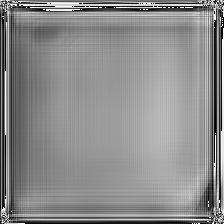

In [108]:
erf

In [110]:
erf.save('wtf.png')

In [80]:
#sd = np.std(field)
#m = np.mean(field)

In [87]:
#q = (field - np.mean(field))/np.std(field)

In [98]:
#field = (field-np.min(field))/(np.max(field)-np.min(field))

# conv filter

In [146]:
# Visualize conv filter
#kernels = model.conv1.weight.detach()
kernels = model.encoder._conv_stem.weight.detach()

In [194]:
model.encoder._conv_stem

Conv2dStaticSamePadding(
  1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)

In [153]:
kernels.size()

torch.Size([32, 1, 3, 3])

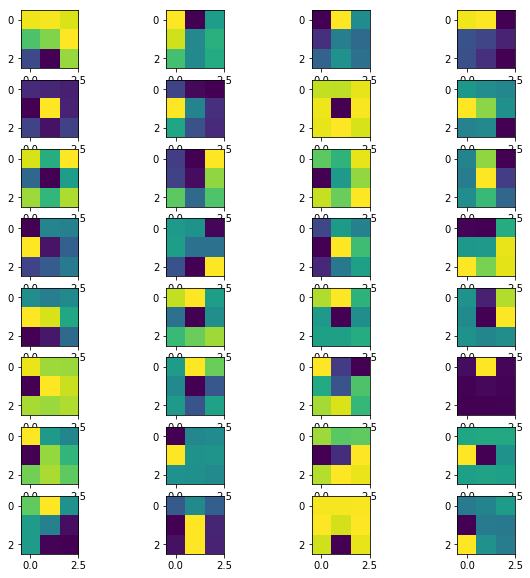

In [159]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(32):
    plt.subplot(8,4,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(kernels[i].cpu().squeeze())

plt.show()

In [198]:
kernels2 = model.encoder._blocks[0]._depthwise_conv.weight.detach()

In [199]:
kernels2.size()

torch.Size([32, 1, 3, 3])

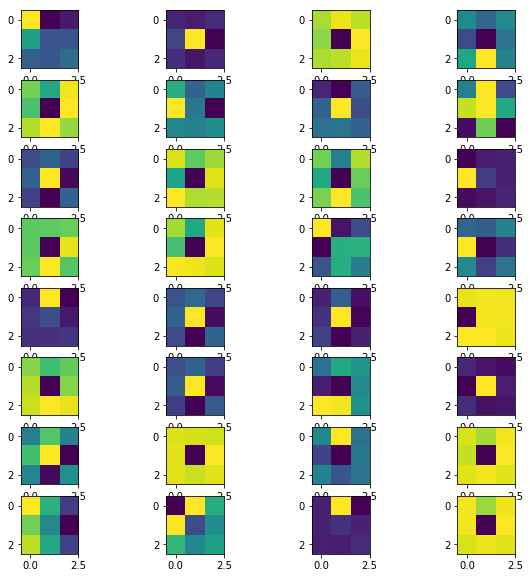

In [200]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(32):
    plt.subplot(8,4,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(kernels2[i].cpu().squeeze())

plt.show()

In [168]:
from scipy.signal import convolve2d

In [181]:
im = img[:,:,0]

In [190]:
im.shape

(200, 256)

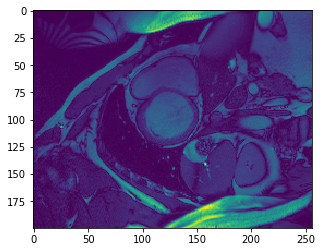

In [182]:
plt.imshow(im);

In [191]:
im_conv1 = convolve2d(kernels[6].cpu().squeeze(), im, mode='valid')

In [193]:
im_conv1.shape

(198, 254)

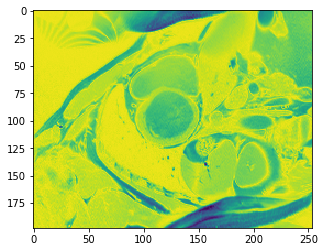

In [192]:
plt.imshow(im_conv1)

In [206]:
im_conv2 = convolve2d(kernels2[6].cpu().squeeze(), im, mode='valid')

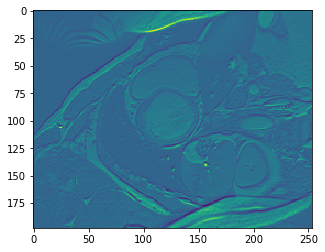

In [207]:
plt.imshow(im_conv2)

In [223]:
#model

In [218]:
from torchsummary import summary


In [233]:
#summary(model, (1, 224, 224))

In [232]:
#summary(model.encoder, (1, 224, 224))

# trash image prediction

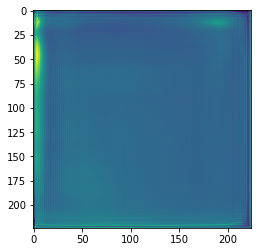

In [246]:
t = np.zeros((224, 224))
pred_t = model(transforms.ToTensor()(t.astype('float32')).unsqueeze(0).to(device))
pred_t = pred_t.squeeze().cpu().detach().numpy()
plt.imshow(pred_t)

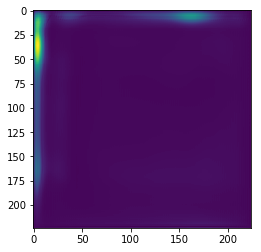

In [244]:
t = np.ones((224, 224))
pred_t = model(transforms.ToTensor()(t.astype('float32')).unsqueeze(0).to(device))
pred_t = pred_t.squeeze().cpu().detach().numpy()
plt.imshow(pred_t)

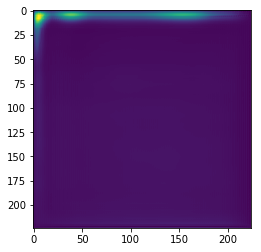

In [256]:
t = np.random.rand(224, 224)
pred_t = model(transforms.ToTensor()(t.astype('float32')).unsqueeze(0).to(device))
pred_t = pred_t.squeeze().cpu().detach().numpy()
plt.imshow(pred_t)

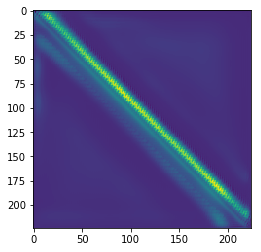

In [258]:
t = np.eye(224, 224)
pred_t = model(transforms.ToTensor()(t.astype('float32')).unsqueeze(0).to(device))
pred_t = pred_t.squeeze().cpu().detach().numpy()
plt.imshow(pred_t)

In [283]:
cat = Image.open('cat.jpeg').convert('L')

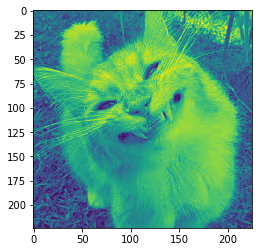

In [284]:
plt.imshow(cat)

In [285]:
cat = np.array(cat)

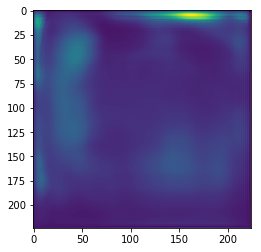

In [286]:
pred_t = model(transforms.ToTensor()(cat.astype('float32')).unsqueeze(0).to(device))
pred_t = pred_t.squeeze().cpu().detach().numpy()
plt.imshow(pred_t)